# ptt的網路分析(network analysis)
#### 近期天下的專題[輿論戰爭](https://www.cw.com.tw/article/article.action?id=5093610&fbclid=IwAR3NXtzdUBrUYBPPepMVzRXwY2tGZj6B84QzjWyPaIgjBL8QnSQjSOU6EeI#_=_)，點出在八卦或政黑有些操作的跡象，其中有些網路分析的技術，這裡嘗試重現相關分析。


### 1. import 網路分析常用的package [networkx](https://networkx.github.io/)
#### 資料取樣自ptt八卦版2018-07-15，可直接用jwliny在github的[ptt-web-crawler](https://github.com/jwlin/ptt-web-crawler)，不用自己寫爬蟲，安裝完後直接下指令(超佛!
#### python -m PttWebCrawler -b PublicServan -i 100 200
#### python crawler.py -b 看板名稱 -i 起始索引 結束索引 (設為負數則以倒數第幾頁計算) 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import operator
from collections import Counter
from IPython.display import Image 

In [2]:
path = 'Gossiping-4800-4900.json'

In [3]:
ptt_df = pd.read_json(path, encoding='utf8')

### 2. 來看看一篇文章的json長怎樣吧!

In [4]:
ptt_df.loc[0].values

array([{'date': 'Sun Jul 15 00:33:00 2018', 'messages': [{'push_tag': '推', 'push_userid': 'jeff0811', 'push_ipdatetime': '111.254.35.228 07/15 00:33', 'push_content': '哈哈'}, {'push_tag': '推', 'push_userid': 'wyvernlee', 'push_ipdatetime': '218.164.6.136 07/15 00:33', 'push_content': '虧雞沒有台灣價值，對西瓜有威脅'}, {'push_tag': '→', 'push_userid': 'jeff0811', 'push_ipdatetime': '111.254.35.228 07/15 00:33', 'push_content': '虧你想出這麼多特有ID'}, {'push_tag': '推', 'push_userid': 'yadogdog', 'push_ipdatetime': '36.237.83.17 07/15 00:35', 'push_content': '明天場 阿伯記得把新營的太子爺搬上台'}, {'push_tag': '→', 'push_userid': 'bybe', 'push_ipdatetime': '49.216.179.202 07/15 00:35', 'push_content': 'ㄧ年才一次ㄟ 幫幫忙'}, {'push_tag': '推', 'push_userid': 'bobsun', 'push_ipdatetime': '49.218.2.150 07/15 00:35', 'push_content': '警察本身就是笑話阿XDDDD'}, {'push_tag': '推', 'push_userid': 'jyings0303', 'push_ipdatetime': '36.234.25.246 07/15 00:35', 'push_content': '你那id 很有05年代線上遊戲風'}, {'push_tag': '推', 'push_userid': 'zenan321', 'push_ipdatetime

### 3. 整理資料：推文作為source，發文作為target，主要是覺得推文作為主動方，觀察是否有大量互相推文的現象

In [5]:
rs_df = pd.DataFrame()

for x in ptt_df.itertuples():
    
    ##資料有點大，先取50篇文章
    if x.Index > 50:
        continue
    
    ##先把文章資料轉為DataFrame
    art = pd.DataFrame([x.articles])
    
    ##如果發文沒有人推，直接濾除
    if art.messages[0] == []:
        continue
    
    #作者 id 有中文，但推文 id只有英文，統一用 英文id 作為Key
    author_id = art.author.replace(r'\([^)]*\)', '', regex=True).values[0].replace(' ', '')
    
    reply = pd.DataFrame(art.messages.values[0])
    #push_ip_ = reply.push_ipdatetime.str.split(' ', n=1, expand=True)
    
    
    temp_df = reply[['push_userid']].copy()
    temp_df['target'] = author_id
    
    ##以發文日期作為推文的估計值，因為push_ipdatetime的ip 跟 datetime放在一起，有些只有datetime 沒有ip，好像跟RE 有關....
    temp_df['date'] = art.date[0]
    ##欄位重新命名，push_userid 改為 source
    temp_df.rename({'push_userid':'source'}, axis=1, inplace=True)
    
    if rs_df.empty:
        rs_df = temp_df
    else:
        rs_df = rs_df.append(temp_df)

#### 3-1. 文章資料

In [6]:
art

,article_id,article_title,author,board,content,date,ip,message_conut,messages
0,M.1531587403.A.CEA,[問卦] 何謂腰馬合一?,wilson5566 (拉拉鍊夾到鳥毛),Gossiping,八卦溫拿 水水 帥帥 潮潮 安安安安 我今天走在市區的路上 突然路邊出現一個撿回收的年輕人對...,Sun Jul 15 00:56:40 2018,122.118.115.3,"{'count': 4, 'neutral': 3, 'all': 7, 'boo': 0,...","[{'push_tag': '→', 'push_userid': 'ERQQ', 'pus..."


#### 3-2. 回應資料

In [7]:
reply.head()

,push_content,push_ipdatetime,push_tag,push_userid
0,腰跟馬子撞在一起,1.171.137.16 07/15 00:57,→,ERQQ
1,五樓肛屌合一,114.24.119.250 07/15 00:57,→,bonfferoni
2,深蹲,39.12.136.26 07/15 00:57,推,Dinenger
3,前面有個腰痛的五毛你可以問他,111.248.159.139 07/15 00:57,推,SpermFriend
4,狗公腰 一字馬 合而為一,36.225.162.121 07/15 00:57,推,JCS15


## 4. 輸出檔案，給開源軟體Gephi使用

In [8]:
rs_df.head()

,source,target,date
0,jeff0811,sqark912,Sun Jul 15 00:33:00 2018
1,wyvernlee,sqark912,Sun Jul 15 00:33:00 2018
2,jeff0811,sqark912,Sun Jul 15 00:33:00 2018
3,yadogdog,sqark912,Sun Jul 15 00:33:00 2018
4,bybe,sqark912,Sun Jul 15 00:33:00 2018


In [9]:
max(pd.to_datetime(rs_df.date.unique()))

Timestamp('2018-07-15 00:56:40')

In [10]:
rs_df.date = pd.to_datetime(rs_df.date)

In [11]:
rs_df.to_csv('ptt.csv', index=False)

## 5. 把DataFrame轉為有向圖

In [12]:
G = nx.from_pandas_edgelist(rs_df, source='source', target='target', create_using=nx.DiGraph())

### 5-1. 看一下degree(in_degree + out_degree)前10名吧!
#### out-degree 外度數: 某個id留言的數量
#### in-degree 輸入度: 某個id「被」留言的數量
#### 翻譯名稱參考：http://terms.naer.edu.tw/detail/2378473/

In [13]:
#設定top幾
rnk = 20

deg_g = dict(G.degree)
top_deg_node = [ x[0] for x in sorted(deg_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]]
sorted(deg_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]

[('zoosleep', 76),
 ('On1y', 55),
 ('sqark912', 51),
 ('evachen5428', 40),
 ('giorno78', 33),
 ('bossun851020', 27),
 ('popy8789', 26),
 ('mstory', 19),
 ('wavelet', 19),
 ('noonecare', 19),
 ('TtTt4', 19),
 ('Boner', 18),
 ('wwf0322', 16),
 ('Firstshadow', 13),
 ('wwer0916', 13),
 ('OrzOGC', 12),
 ('littlethe', 12),
 ('FlashWolves', 11),
 ('rrrroger', 11),
 ('a240daniel', 11)]

### 5-1. 看一下pagerank前10名吧!

In [14]:
pg_rnk_g = nx.pagerank(G)
top_pg_rnk_node = [ x[0] for x in sorted(pg_rnk_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]]

In [15]:
sorted(pg_rnk_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]

[('zoosleep', 0.052235639253159646),
 ('sqark912', 0.04141060214156507),
 ('Firstshadow', 0.039611888130797454),
 ('On1y', 0.037719844136460096),
 ('kenjohn', 0.033371326089946855),
 ('evachen5428', 0.028407697150471138),
 ('bossun851020', 0.023489968465474298),
 ('giorno78', 0.02093555833141337),
 ('wavelet', 0.014966251664346529),
 ('popy8789', 0.014053298879971607),
 ('Boner', 0.013650766348522142),
 ('mstory', 0.012227393311221748),
 ('mmc109815038', 0.012092859832059957),
 ('nk950357', 0.01088736732633198),
 ('TtTt4', 0.01036573574532155),
 ('FlashWolves', 0.010261033467952674),
 ('rrrroger', 0.01025177290515703),
 ('OrzOGC', 0.010191197872455952),
 ('noonecare', 0.010036306628721924),
 ('wwf0322', 0.0087364661608986)]

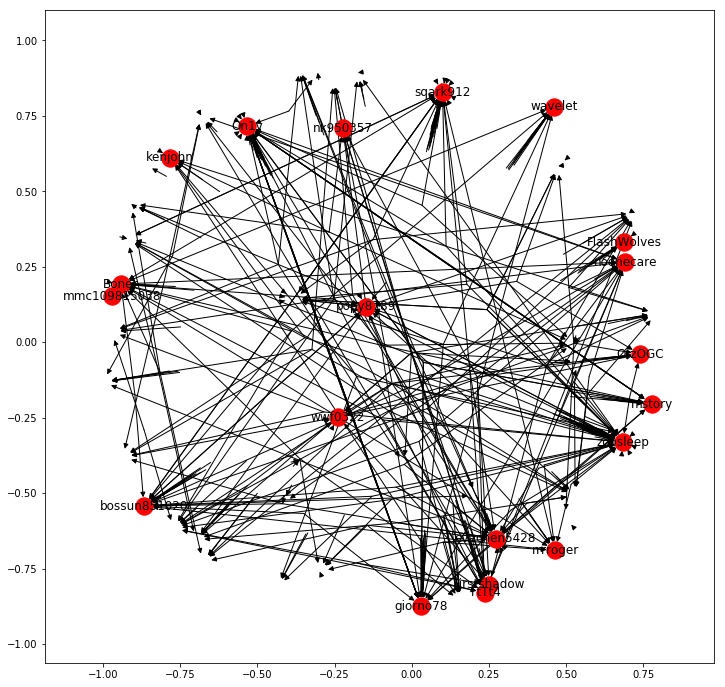

In [16]:
plt.figure(figsize=(12, 12))#nodelist

nx.draw_networkx(G, with_labels=True, nodelist=top_pg_rnk_node, labels={x:x for x in top_pg_rnk_node})

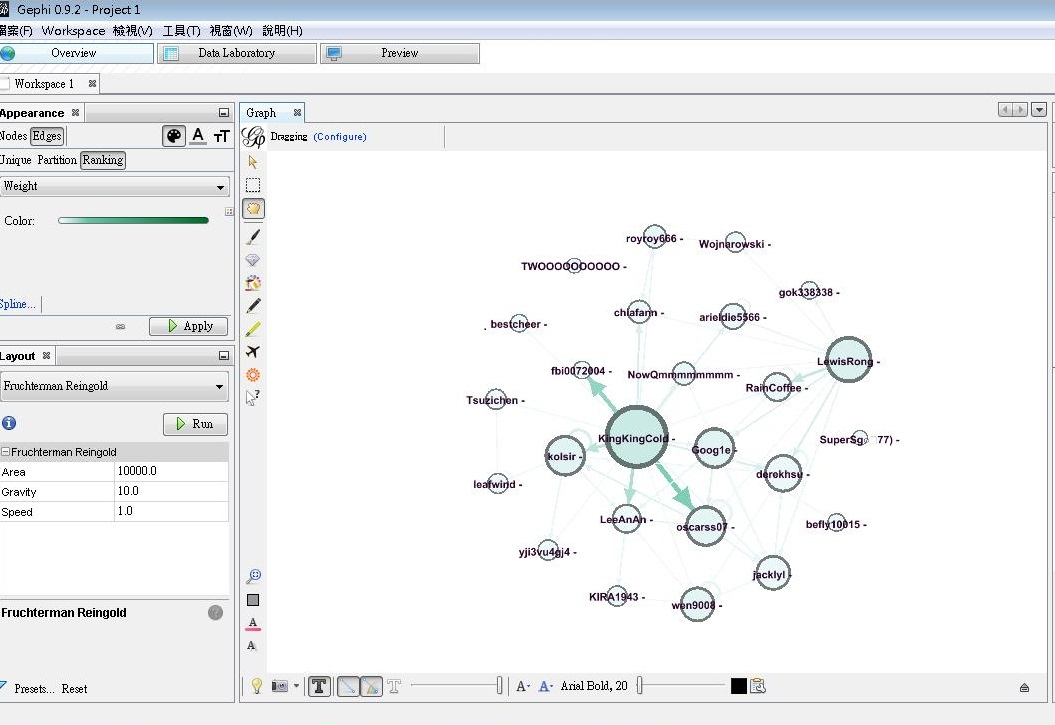

In [17]:
Image(filename = 'ptt.jpg')

# ToDo
#### 1. https://pttpedia.fandom.com/zh/wiki/KingKingCold 比對ptt名人
#### 2. 解析ip(國家) 與 回文時間
#### 3. 增加資料區間
#### 4. [add dynamic graph](https://seinecle.github.io/gephi-tutorials/generated-html/converting-a-network-with-dates-into-dynamic.html#_1_dynamic_nodes_with_a_start_date)

In [18]:
#pd.to_datetime(reply.push_ipdatetime[0]+ ' ' + str(art_year) , format='%m/%d %H:%M %Y')
#(reply.push_ipdatetime+ ' ' + str(art_year)).apply(pd.to_datetime(x, format='%m/%d %H:%M %Y'), errors='coerce')
#pitchtype[col].map(lambda x: x.replace(' %','') if type(x) == str else x)